<a href="https://colab.research.google.com/github/manikcb/project-phase2/blob/main/cnn_rmsprop_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 110.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 103.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd


In [32]:
import numpy as np
import pandas as pd

In [33]:
import pickle

In [34]:
from collections import defaultdict

In [35]:
import re

In [36]:
from bs4 import BeautifulSoup

In [37]:
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not

In [38]:
from keras.preprocessing.text import Tokenizer

In [39]:
from keras.preprocessing.sequence import pad_sequences

In [40]:
from keras.utils.np_utils import to_categorical

In [41]:
from keras.layers import Embedding

In [42]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model

In [43]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [44]:
plt.switch_backend('agg')
%matplotlib inline

In [46]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [48]:
# reading data
df = pd.read_csv("/content/cyberdata1.csv")
#df = pd.read_excel('/content/cyberdata1.csv')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['category'])))

Shape of dataset  (9107, 2)
Index(['message', 'category'], dtype='object')
No. of unique classes 2


In [49]:
macronum=sorted(set(df['category']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['category']=df['category'].apply(fun)
     

In [51]:
def clean_str(string):
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()
     

In [53]:

texts = []
labels = []


for idx in range(df.message.shape[0]):
    text = BeautifulSoup(df.message[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['category']:
    labels.append(idx)
     

<ipython-input-53-34a5d2c33438>:6: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-53-34a5d2c33438>:6: MarkupResemblesLocatorWarning:

The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



In [54]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 21632


In [55]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
     

Shape of Data Tensor: (9107, 1000)
Shape of Label Tensor: (9107, 2)


In [58]:
!ls
!pwd

cyberdata1.csv	drive  sample_data
/content


In [59]:
embeddings_index = {}
f = open('/content/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 19561 word vectors in Glove 6B 100d.


In [60]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [61]:

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         2163300   
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)               

In [62]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Epoch 1/15
3639/3643 [============================>.] - ETA: 0s - loss: 0.1686 - acc: 0.9485
Epoch 1: val_acc improved from -inf to 0.97694, saving model to model_cnn.hdf5
3643/3643 [==============================] - 39s 9ms/step - loss: 0.1684 - acc: 0.9485 - val_loss: 0.1638 - val_acc: 0.9769
Epoch 2/15
3641/3643 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9805
Epoch 2: val_acc improved from 0.97694 to 0.97968, saving model to model_cnn.hdf5
3643/3643 [==============================] - 29s 8ms/step - loss: 0.1250 - acc: 0.9805 - val_loss: 0.3763 - val_acc: 0.9797
Epoch 3/15
3635/3643 [============================>.] - ETA: 0s - loss: 0.1179 - acc: 0.9845
Epoch 3: val_acc did not improve from 0.97968
3643/3643 [==============================] - 22s 6ms/step - loss: 0.1178 - acc: 0.9845 - val_loss: 0.2237 - val_acc: 0.9797
Epoch 4/15
3637/3643 [============================>.] - ETA: 0s - loss: 0.1043 - acc: 0.9902
Epoch 4: val_acc improved from 0.97968 to 0.98407

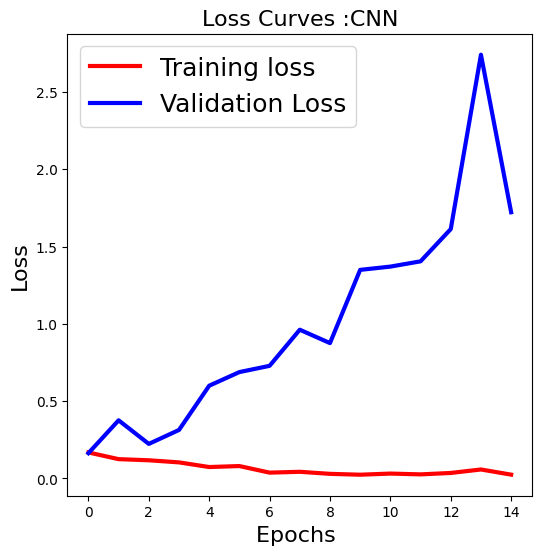

In [63]:

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

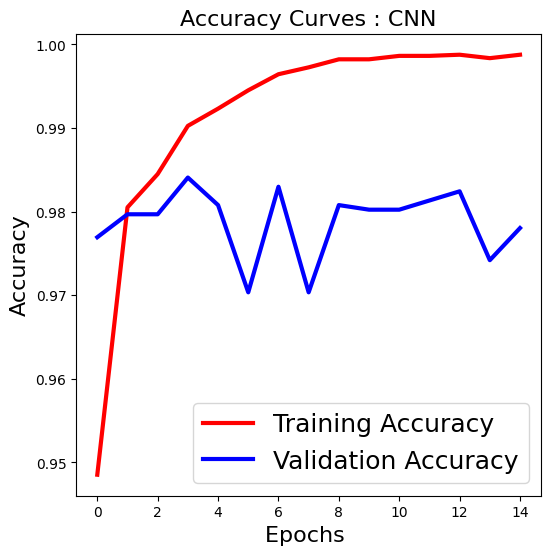

In [64]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()
     

In [65]:
# Import pandas library
import pandas as pd

# initialize list elements
x=input("Enter your comment : ")

data = []
data.append(x)

# Create the pandas DataFrame with column name is provided explicitly
df1 = pd.DataFrame(data, columns=['comment'])
y_predicted = model.predict(df1)
y_predicted = y_predicted.flatten()
import numpy as np



y_predicted = np.where(y_predicted > 0.5, 1, 0)
if y_predicted == 1:
  print("Entered comment is cyberharrased")
else:
  print("entered comment is not cyberharrased")

Enter your comment : hey you dumb ass nigger


ValueError: ignored